In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import os
import torchvision.transforms as transforms
from pycocotools.cocoeval import COCOeval
import numpy as np


### Create custom dataset class

In [69]:
class Vegeta(Dataset):
    def __init__(self, root, annotation, transforms= None, subset_size=None):
    
        self.root = root #for storing the root directory path, will require later
        # self.annotation = annotation  #variable with location of the annotation file
        self.transforms = transforms #assigning transformations applied to the images
        self.coco = COCO(annotation)  #COCO is an object from pycocotools whcih provides access to different functions to access the dataset annotations in COCO format
        self.ids = list(sorted(self.coco.imgs.keys()))  #self.coco.imgs gives keys are image IDs and the values contain metadata (such as file names, height, width, etc.) about each image in the dataset.

        if subset_size is not None:
            self.ids = self.ids[:subset_size]

    def __getitem__(self, index): #way to access the class as a collection using the index
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        coco = self.coco
        img_id = self.ids[index]  #index will take you to the image id, we have sorted the ids above
        ann_ids = coco.getAnnIds(imgIds=img_id) #gets the annotation ids for that image_id, an image_id can have multiple annotations id
        coco_annotation = coco.loadAnns(ann_ids) #returns a list of annotations for that particular annotation_ids for an image_id
        
        """
        coco.loadImgs method loads metadata about the image with the given image_id, [0]
        because the method returns a list of image 
        metadata dictionaries and we consider only first as we can get file path from any of them 
        """
        img_path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, img_path)).convert('RGB')

        num_objs = len(coco_annotation) # returns the number of objects that are present in the image, could be 1 or 3 etc
        boxes = []
        labels = []

        for i in range(num_objs): #since we can have multiple objs
            ## annotation Format: [x, y, width, height]
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])  #add bb coordinates to list
            labels.append(coco_annotation[i]['category_id'])  #add labels to list 

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            image_id = torch.tensor([img_id])
            
            #value of 0 indicates that the object is not part of a crowd, and if 1, it would indicate that the object is part of a crowd 

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id

            if self.transforms is not None:
                img = self.transforms(img)
            return img, target

    def __len__(self):  #special function of class to find the length of the dataset
        return len(self.ids)

#### Load the training and validation data

In [70]:
def get_transform(train):
    transform_list = [
        transforms.ToTensor(),
    ]
    # if train:
    #     transform_list.append(transforms.RandomHorizontalFlip(0.5)) # image transformation that randomly flips the image horizontally with a probability of 0.5 (50%)
    return transforms.Compose(transform_list) 

#load the training data
trainset = Vegeta(root='data/train', annotation='data/train_annot/train_an_coco.json', transforms=get_transform(train=True), subset_size=1)
train_loader = DataLoader(trainset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

#load the validation data
validationset = Vegeta(root='data/val', annotation='data/val_annot/val_an_coco.json', transforms=get_transform(train=False), subset_size=1)
val_loader = DataLoader(validationset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


#### to load subset data

In [50]:
subset_dataset = Subset(trainset, indices=range(2))  # Test with 2 samples
subset_loader = DataLoader(subset_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

for images, targets in subset_loader:
    print("Batch loaded successfully!")

Batch loaded successfully!


#### Load the pre-trained model

In [71]:
def get_faster_rcnn_model_with_class(num_classes):
    """
    Function to get a model last layer equalling your class
    """
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features 
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes=2 #1 class + background
model = get_faster_rcnn_model_with_class(num_classes)  # 1 classes + background

In [72]:
#shifting model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device", device)
model.to(device)

device cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### Training the model and saving every epoch

In [73]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005) #model hyperparameters and loss updation
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# # Early stopping parameters
# patience = 3  # Number of epochs to wait for improvement
# best_val_loss = np.inf
# epochs_without_improvement = 0

num_epochs = 10
annotation_path = 'data/val_annot/val_an_coco.json'
coco = COCO(annotation_path)
best_mAP = 0.0
score_threshold = 0.5

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [74]:
def compute_mAP(model, val_loader, device, coco_gt, score_threshold):
    model.eval()
    predictions = []
      # Adjust based on your model's confidence
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            batch_predictions = model(images)
            
            for pred, target in zip(batch_predictions, targets):
                boxes = pred['boxes'].cpu().numpy()
                labels = pred['labels'].cpu().numpy()
                scores = pred['scores'].cpu().numpy()
                
                # Filter predictions
                keep_indices = np.where((scores >= score_threshold) & (labels != 0))[0] #not considering Background as it is class 0
                for idx in keep_indices:
                    xmin, ymin, xmax, ymax = boxes[idx]
                    width = xmax - xmin
                    height = ymax - ymin
                    bbox_coco = [xmin, ymin, width, height]
                    
                    predictions.append({
                        'image_id': target['image_id'].item(),
                        'category_id': int(labels[idx]),
                        'bbox': bbox_coco,
                        'score': float(scores[idx])
                    })
    
    if not predictions:
        print("No predictions to evaluate.")
        return 0.0
    
    coco_dt = coco_gt.loadRes(predictions)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    return coco_eval.stats[0]

In [75]:
for epoch in range(0, num_epochs):
    model.train() #setting model to training mode
    train_loss = 0
    for images, targets in train_loader: #iterate over data
        images = list(image.to(device) for image in images) #moving all the images to device
        targets = [{key: value.to(device) for key, value in t.items()} for t in targets] #target will have labels and BB, used dict comprehension
        
        #loss dictionary
        optimizer.zero_grad() #makes gradient zero for next iteration
        loss_dict = model(images, targets) #gets the loss 
        losses = sum(loss for loss in loss_dict.values()) #adds the loss
        
        losses.backward() #backprop
        optimizer.step() #

        train_loss += losses.item()
    #update learning rate 
    lr_scheduler.step()
    
    
    #validation file 
    coco_gt = COCO(annotation_path)
    mAP = compute_mAP(model, val_loader, device, coco_gt, score_threshold)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss/len(train_loader):.4f}, mAP: {mAP:.4f}")
    
    # Save the best model based on mAP
    if mAP > best_mAP:
        best_mAP = mAP
        torch.save(model.state_dict(), 'best_model.pth')
    
#         # Save the model's state dictionary after every epoch
#     model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
#     torch.save(model.state_dict(), model_path)
#     print(f"Epoch {epoch+1}/{num_epochs} Loss: {losses.item()}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
No predictions to evaluate.
Epoch 1/10 - Train Loss: 1.1581, mAP: 0.0000
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
No predictions to evaluate.
Epoch 2/10 - Train Loss: 0.4142, mAP: 0.0000
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
No predictions to evaluate.
Epoch 3/10 - Train Loss: 0.2243, mAP: 0.0000
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
No predictions to evaluate.
Epoch 4/10 - Train Loss: 0.2193, mAP: 0.0000
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
No predictions to evaluate.
Epoch 5/10 - Train Loss: 0.2531, mAP: 0.0000
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
No predictions to evaluate.
Epoch 6/10 - Train Loss: 0.2629, mAP: 0.0000
loading annotations into memory...
Done (t=0.00s)
creating index

## Training finished now only inferencing

#### Loading the saved model and setting it for Inference

In [35]:
model = get_faster_rcnn_model_with_class(num_classes)  # 1 classes + background
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval() 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### visualize the results

In [36]:
def visualize_predictions(image, boxes, labels, scores, threshold=0.5, size = (12, 8)):
    fig, ax = plt.subplots(1, figsize= size) #initialize the axis
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold: #score check
            x, y, w, h = box
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f'{label}: {score:.2f}', color='white', backgroundcolor='red', fontsize=8)

    plt.axis('off')
    plt.title('Predicted bounding boxes', fontsize = 10)
    plt.show()
    plt.close()

#### If you want to run the loop on all the validation images

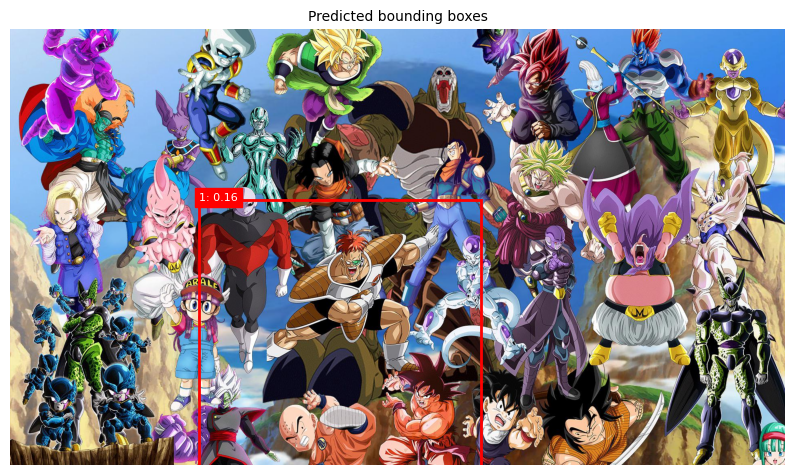

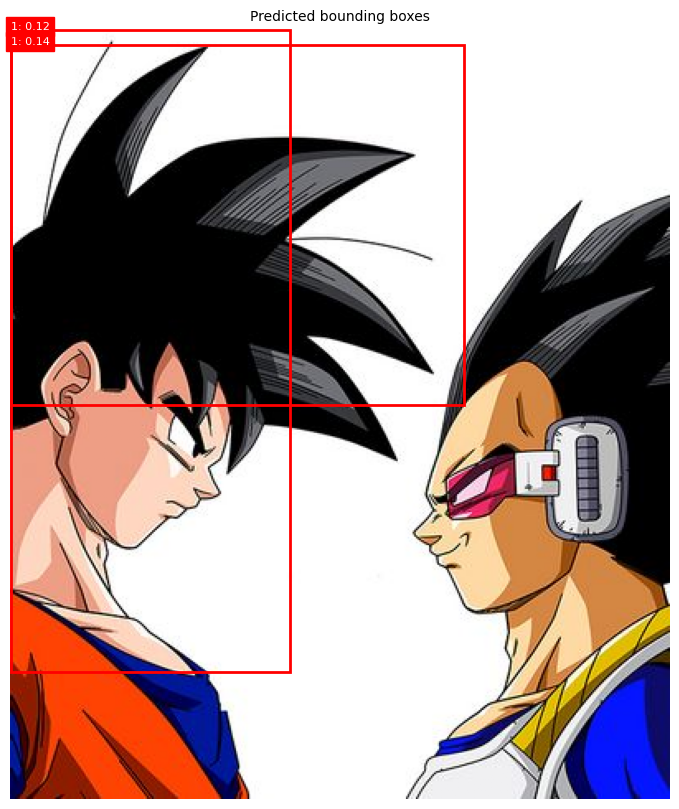

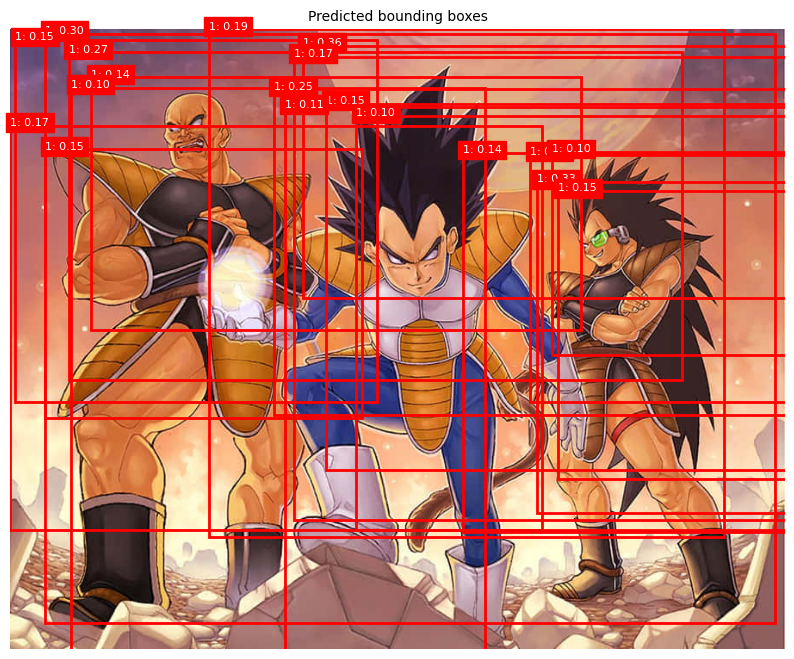

In [42]:
# Visualize predictions on a few validation images

fig_size = (10,10) 
threshold_value = 0.1

for images, targets in val_loader:
    images = list(image.to(device) for image in images) #send to device
    with torch.no_grad():
        predictions = model(images)

    for i, (image, prediction) in enumerate(zip(images, predictions)):
#         image = np.transpose(image.cpu().numpy(), (1,2,0))
        image = image.cpu().permute(1, 2, 0).numpy()  # Convert to X,Y,Z format as image is stored as channel, X, Y
        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()
        visualize_predictions(image, boxes, labels, scores, threshold=threshold_value, size = fig_size)

## Validation on 1 image at a time


In [43]:
# Plot the image with bounding boxes
def plot_image_with_pred_boxes(image, boxes, labels):
    fig, ax = plt.subplots(1, figsize= (10,10)) #no of rows, figure size
    ax.imshow(image)
    
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'Class: {category_id[label]}', color='white', fontsize=12)
    
    plt.title('Image with predicted bounding boxes', fontsize= 10)
    plt.axis('off')
    plt.show()
    plt.close()

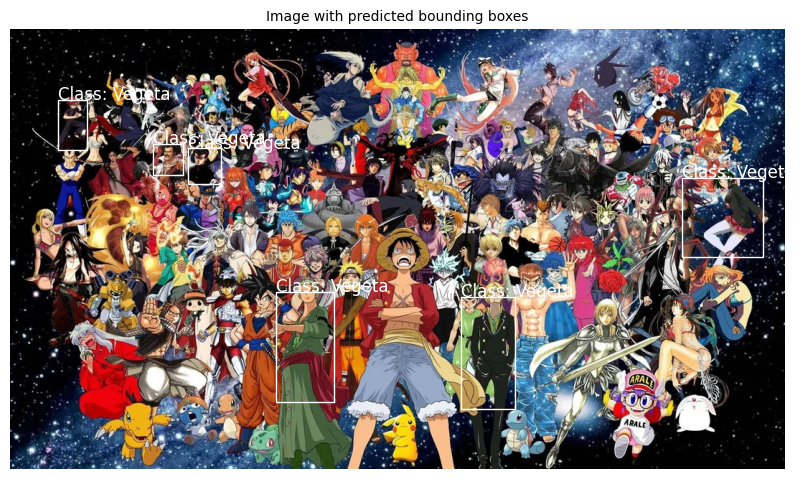

In [44]:
# Define transforms for the image
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the image
image_path = 'data/test/q5khrnrwimu71.jpg'
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device
category_id = ('Background', 'Vegeta')
confidence_threshold = 0.002

# Perform inference
with torch.no_grad():
    prediction = model(image_tensor)

# Extract the predictions
prediction = prediction[0]  # Remove batch dimension
boxes = prediction['boxes'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()

# Filter predictions by confidence threshold

filtered_boxes = boxes[scores > confidence_threshold]
filtered_labels = labels[scores > confidence_threshold]

# Visualize the results
plot_image_with_pred_boxes(image, filtered_boxes, filtered_labels)

#### if you want to get both predicted and original bounding box

In [45]:
# Plot the image with predicted and ground truth bounding boxes
def plot_image_with_gt_and_pred_boxes(image, pred_boxes, pred_labels, gt_boxes, gt_labels):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Draw predicted boxes (in red)
    for box, label in zip(pred_boxes, pred_labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'Pred: {label}', color='r', fontsize=10, backgroundcolor='white')
    
    # Draw ground truth boxes (in green)
    for box, label in zip(gt_boxes, gt_labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'GT: {label}', color='g', fontsize=10, backgroundcolor='white')
    
    plt.title('Image with predicted and ground truth bounding boxes', fontsize= 10)
    plt.axis('off')
    plt.show()
    plt.close()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


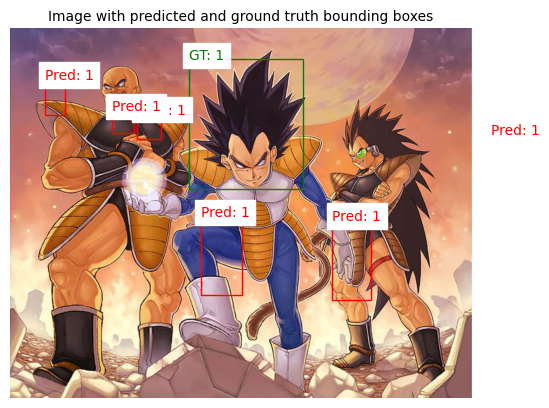

In [46]:

from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# Define transforms for the image
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the image
image_path = 'data/val/majin-vegeta-and-other-dragon-ball-characters-tajyteiulwizv8zz.jpg'
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

annotation_path = 'data/val_annot/val_an_coco.json'
coco = COCO(annotation_path)

# Find the image ID by matching the filename
image_filename = image_path.split('/')[-1]  # Extract filename from path
image_id = None
for img_info in coco.dataset['images']:
    if img_info['file_name'] == image_filename: # stop when you find the image
        image_id = img_info['id']
        break

if image_id is None:
    raise ValueError(f"Image filename '{image_filename}' not found in annotations.")

# Extract ground truth boxes and labels
ann_ids = coco.getAnnIds(imgIds=image_id)
gt_annotations = coco.loadAnns(ann_ids) #load the annotations

# Extract ground truth boxes and labels
gt_boxes = []
gt_labels = []
for ann in gt_annotations:
    xmin, ymin, width, height = ann['bbox']
    xmax = xmin + width
    ymax = ymin + height
    gt_boxes.append([xmin, ymin, xmax, ymax])
    gt_labels.append(ann['category_id'])
    

# Visualize the results
plot_image_with_gt_and_pred_boxes(image, filtered_boxes, filtered_labels, gt_boxes, gt_labels)

#### Evaluate the model using MAP(not sure if this is correct/lookifng for alternatives)

In [64]:

annotation_path = 'data/val_annot/val_an_coco.json'
# Initialize COCO ground truth API
coco_gt = COCO(annotation_path)

# Initialize lists to store predictions
results = []

# Run inference on the validation set
for images, targets in val_loader:
    images = list(image.to(device) for image in images) #sending images to device
    with torch.no_grad(): #to not update the weights
        predictions = model(images)

    # Convert predictions to COCO format
    for i, prediction in enumerate(predictions):
        image_id = targets[i]['image_id'].item()
        boxes = prediction['boxes'].cpu().numpy() #changing tensors to numpy for saving them on disk
        scores = prediction['scores'].cpu().numpy() #changing tensors to numpy for saving them on disk
        labels = prediction['labels'].cpu().numpy() #changing tensors to numpy for saving them on disk

        for box, score, label in zip(boxes, scores, labels):
            x_min, y_min, x_max, y_max = box[0], box[1], box[2] , box[3] #converting to bb format
            width = box[2] - box[0]
            height = box[3] - box[1]
            result = {
                "image_id": image_id,
                "category_id": label.item(),
                "bbox": [x_min, y_min,width,height],  # Convert to [x, y, width, height]
                "score": score.item()
            }
            results.append(result)

# Convert results to COCO format
coco_dt = coco_gt.loadRes(results)

# Run COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Print mAP
print(f"mAP: {coco_eval.stats[0]:.4f}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet